# Improve the Metropolis-Hastings algorithm

Student: Ramón Daniel REGUEIRO ESPIÑO

Email: ramondaniel1999@gmail.com

Group: 2 ("Pierre")

# Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler

In [1]:
import numpy as np
import warnings
warnings.filterwarnings("ignore") 

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

## 1.A – Metropolis-Hastings within Gibbs sampler

We use a MH for each step of the Gibbs when we do not know how to sample.

#### 1. Implement an algorithm which samples the distribution $P_1  (z;\cdot)$ where $z \in \mathbb{R}^2$ ; likewise for the distribution $P_2 (z;\cdot)$  Then, implement an algorithm which samples a chain with kernel $P$.

In [2]:
def log_pi(X,a=10):
    # Log-likelihood for the considered distribution
    return -X[...,0]**2/a**2 -X[...,1]**2 - 0.25*(X[...,0]**2/a**2-X[...,1]**2)**2

def pi(X):
    # Likelihood for the considered distribution from the log-likelihood function
    return np.exp(log_pi(X))

In [3]:
def P1_gen(n_iter,a=10,init=None,sigma_prop=1e-2,progress=True) : 
    # Sample the distribution P1
    if init is None:
        X=np.random.randn(2)
    else:
        X=np.array(init)
    y_0=X[1]
    samples=np.zeros((n_iter,2))
    current_log_pi=log_pi(X,a)
    accepts=0
    attempts=0
    for it in range(n_iter):
        x_0=X[0]
        # generate next move
        x_prop = np.random.normal(x_0, sigma_prop,size=1)
        X_prop=np.array([x_prop[0],y_0])
        # compute the acceptance log-prob
        prop_log_pi=log_pi(X_prop,a)
        log_alpha = current_log_pi-prop_log_pi
        log_alpha = min(0, log_alpha)
        log_u = np.log(np.random.rand())
        if log_u <= log_alpha :
            X=X_prop.copy()
            current_log_pi=prop_log_pi
            accepts+=1
        attempts+=1
        samples[it]=X
    if progress: print('Acceptance rate:',accepts/attempts)
    return samples
    
def P2_gen(n_iter,a=10,init=None,sigma_prop=1e-2,progress=True) : 
    # Sample the distribution P2
    if init is None:
        X=np.random.randn(2)
    else:
        X=np.array(init)
    x_0=X[0]
    samples=np.zeros((n_iter,2))
    current_log_pi=log_pi(X,a)
    accepts=0
    attempts=0
    for it in range(n_iter):
        y_0=X[1]
        # generate next move
        y_prop = np.random.normal(y_0, sigma_prop,size=1)
        X_prop=np.array([x_0,y_prop[0]])
        # compute the acceptance log-prob
        prop_log_pi=log_pi(X_prop,a)
        log_alpha = current_log_pi-prop_log_pi
        log_alpha = min(0, log_alpha)
        log_u = np.log(np.random.rand())
        if log_u <= log_alpha :
            X=X_prop.copy()
            current_log_pi=prop_log_pi
            accepts+=1
        attempts+=1
        samples[it]=X
    if progress: print('Acceptance rate:',accepts/attempts)
    return samples
    

In [4]:
def MHwG(n_iter,a,init=None,progress=True,sigma_prop=[1e-2,1e-2],prob_k=0.5):
    # Metropolis-Hastings with Gibbs for the considered distribution
    accepts=np.zeros(2)
    attempts=np.zeros(2)
    if init is None:
        x=np.random.randn(2)
    else:
        x=np.array(init)
    current_log_pi=log_pi(x,a)
    
    samples=np.zeros((n_iter,2))
    mask=np.eye(2)
    for i in range(n_iter):
        k=np.random.rand()
        if k<prob_k:
            k=0
        else:
            k=1
        # Generate new move
        u=np.random.randn()*sigma_prop[k]
        x2=x+mask[k]*u
        # compute the acceptance log-prob
        log_alpha=log_pi(x2,a)-current_log_pi
        if np.log(np.random.rand())<log_alpha:
            x=x2
            current_log_pi=log_pi(x,a)
            accepts[k]+=1
            
        attempts[k]+=1
        samples[i]=x
    if progress: print('Acceptance rates',accepts/attempts)
    return samples

#### 2. Run the algorithm with $a=10$ and standard deviations of the proposal distributions chosen as follows: $(\sigma_1,\sigma_2=(3, 3)$. Discuss the performance of the algorithm in this situation.


Acceptance rates [0.86087131 0.26080893]


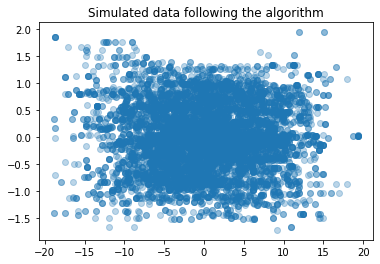

In [5]:
a=10.0
n_iter=10000
x=MHwG(n_iter,a,sigma_prop=[3,3])

Nb_burn=int(n_iter/10)
plt.figure()
plt.scatter(x[Nb_burn:,0],x[Nb_burn:,1],alpha=0.3)
plt.title('Simulated data following the algorithm')
plt.show()

From the figure, we might assume that our data are not well sampled as there is a too strong correlation. We can see it specially in the X axis as the acceptance rate of the $x$ variable is very high if we compare it with the acceptance rate for the $y$ variable.

#### 3. How could the performance of the above algorithm be improved ? Propose two methods.


Firstly, one tool might be to change the probability of selecting each variable from $\frac{1}{2}$ to a value more adequate to the obtained acceptance rates. 

Acceptance rates [0.86837721 0.24946421]


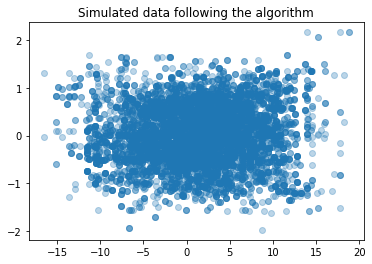

In [6]:
x_prob=MHwG(n_iter,a,sigma_prop=[3,3],prob_k=0.3)
plt.figure()
plt.scatter(x_prob[Nb_burn:,0],x_prob[Nb_burn:,1],alpha=0.3)
plt.title('Simulated data following the algorithm')
plt.show()


Secondly, to change the selected values for the $\sigma$ values of the algorithm. For instance, increasing the $\sigma_1$ parameter.

Acceptance rates [0.69333065 0.27337701]


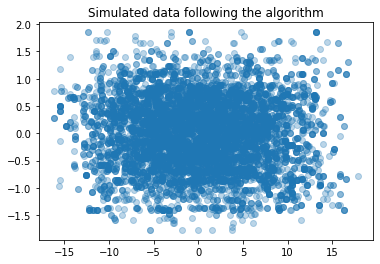

In [7]:
x_sigma=MHwG(n_iter,a,sigma_prop=[7,3])
plt.figure()
plt.scatter(x_sigma[Nb_burn:,0],x_sigma[Nb_burn:,1],alpha=0.3)
plt.title('Simulated data following the algorithm')
plt.show()

## 1.B – Adaptive Metropolis-Hastings within Gibbs sampler

#### 1. Implement the adaptative Metropolis-Hastings within Gibbs sampler and test the algorithm on the density $\pi$ defined in the part A: Using auto-correlation plots (use a built-in function), compare the performance of the algorithm with or without adaptation.

$R_{x,y}=\frac{\sigma_{x,y}}{\sigma_x \sigma_y} \in [-1,1]$ where $\sigma_x  =\frac{1}{N-1} \sum_{i=1}^{n} (x_i - \overline{x})^2$.

In [8]:
def crosscorr(x,y,max_lag=None):
    #  cross-correlation function
    if max_lag is None:
        max_lag=len(x)
    sx=pd.Series(x)
    sy=pd.Series(y)
    res=np.zeros(max_lag)
    for lag in range(1,max_lag):
        res[lag]=sx.corr(sy.shift(lag))
    res[0]=1
    return res

In [9]:
def adaptative_mhwg(n_batches,batch_size,d,log_like=log_pi,init=None):
    # Adaptative Metropolis-Hastings with Gibbs sampler
    if init is None:
        x=np.random.randn(d)
    else:
        x=np.array(init)
    accepts=np.zeros((n_batches,d))
    current_log_pi=log_like(x)
    
    samples=np.zeros((n_batches*batch_size,d))
    L=np.zeros((n_batches,d))
    mask=np.eye(d)
    it=range(n_batches)
    for i in it:
        # Do the MW_wG step
        for b in range(batch_size):
            for k in range(d):
                # generate next move
                u=np.random.randn()*np.exp(L[i-1,k])
                x2=x+mask[k]*u
                # compute acceptance log-prob
                log_pi_prop=log_like(x2)
                log_alpha=log_pi_prop-current_log_pi
                if np.log(np.random.rand())<log_alpha:
                    x=x2
                    current_log_pi=log_pi_prop
                    accepts[i,k]+=1
            samples[i*batch_size+b]=x
        accepts[i]/=batch_size
        
        # update the variance parameters
        delta=min(0.05,1/np.sqrt(i+1))
        for k in [0,1]:
            e=2*(accepts[i,k]>0.24)-1
            L[i,k]=L[i-1,k]+e*delta
    return samples,accepts,L

In [10]:
n_iter=10000
results_new,accepts,L=adaptative_mhwg(n_iter,100,d=2,log_like=log_pi)

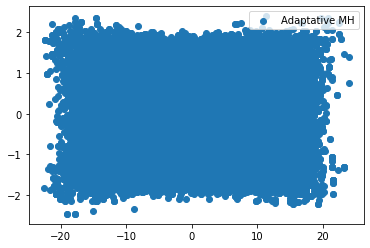

In [11]:
N_burn=int(n_iter/10)
plt.figure()
plt.scatter(results_new[N_burn:,0],results_new[N_burn:,1],label="Adaptative MH")
plt.legend(loc='upper right')
plt.show()

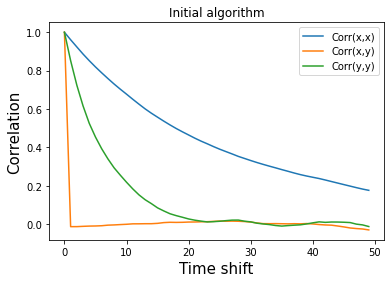

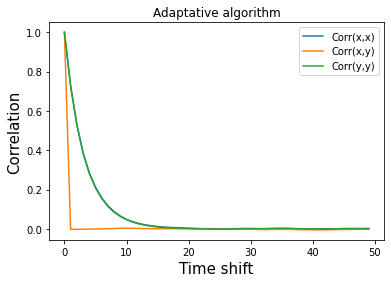

In [12]:
plt.figure()
plt.plot(crosscorr(x[:,0],x[:,0],max_lag=50),label='Corr(x,x)')
plt.plot(crosscorr(x[:,0],x[:,1],max_lag=50),label='Corr(x,y)')
plt.plot(crosscorr(x[:,1],x[:,1],max_lag=50),label='Corr(y,y)')
plt.xlabel('Time shift',fontsize=15)
plt.ylabel('Correlation',fontsize=15)
plt.legend(loc='upper right',fontsize=10)
plt.title('Initial algorithm')
plt.show()
plt.figure()
plt.plot(crosscorr(results_new[:,0],results_new[:,0],max_lag=50),label='Corr(x,x)')
plt.plot(crosscorr(results_new[:,0],results_new[:,1],max_lag=50),label='Corr(x,y)')
plt.plot(crosscorr(results_new[:,1],results_new[:,1],max_lag=50),label='Corr(y,y)')
plt.xlabel('Time shift',fontsize=15)
plt.ylabel('Correlation',fontsize=15)
plt.legend(loc='upper right',fontsize=10)
plt.title('Adaptative algorithm')
plt.show()

We can see that in the correlation plots that the sample obtained using the Adaptative version the correlation curves converge quickly to zero. This cannot be seen in the original version. So, the adaptative version produce samples that can be considered random, which cannot be stated for the original version.

#### 2. We can also compare the performance of our algorithm on more complicated target densities. For example centered d-dimensional Gaussian $\mathcal{N}(0,\Sigma)$ or "banana"-shaped density as in TP 2:
$ \forall x=(x_1,x_2\cdots, x_d)\in \mathbb{R}^d, \\
f_B(x) \propto \exp \left(-\frac{x_1^2}{200}-\frac{1}{2}(x_2+B \, x_{1}^2-100 \, B)^2-\frac{1}{2}(x_{3}^2+\cdots +x_{d}^2)\right).$

In [13]:
with open('tmalaexcov.txt') as f:
    array = []
    for line in f: # read rest of lines
        array.append([float(x) for x in line.split()])
cov_matrix=np.asarray(array)

In [14]:
def log_likelimulti(residuals,cov_matrix=cov_matrix):
    # log-likelihood for the d-dimensional centered Gaussian
    return -0.5 * (np.log(np.linalg.det(cov_matrix)) + residuals.T.dot(np.linalg.inv(cov_matrix)).dot(residuals) + 2 * np.log(2 * np.pi))

In [15]:
def log_fB(X,d=20,B=0.1):
    # log-likelihood of the banana shaped distribution
    return(-(X[0]**2)/200.-(0.5)*(X[1]+B*X[0]**2-100*B)**2-(0.5)*(np.sum(X[2:]**2)))

In [16]:
results_multi,accepts_multi,L_multi=adaptative_mhwg(2000,100,d=20,log_like=log_likelimulti,init=None)

In [17]:
results_banana,accepts_B,L_b=adaptative_mhwg(2000,100,d=20,log_like=log_fB,init=None)

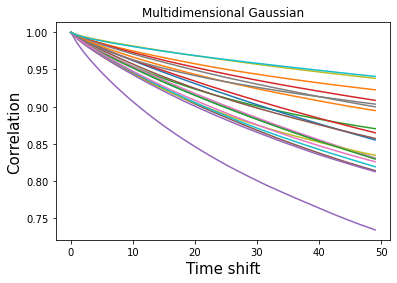

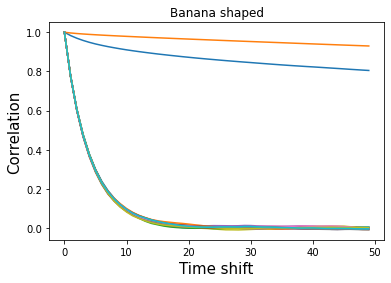

In [18]:
plt.figure()
for i in range(20):
    plt.plot(crosscorr(results_multi[:,i],results_multi[:,i],max_lag=50))
plt.xlabel('Time shift',fontsize=15)
plt.ylabel('Correlation',fontsize=15)
plt.title('Multidimensional Gaussian')
plt.show()


plt.figure()
for i in range(20):
    plt.plot(crosscorr(results_banana[:,i],results_banana[:,i],max_lag=50))
plt.xlabel('Time shift',fontsize=15)
plt.ylabel('Correlation',fontsize=15)
plt.title('Banana shaped')
plt.show()

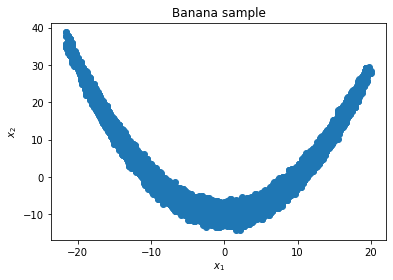

In [19]:
Nb_burn=100
plt.figure()
plt.scatter(results_banana[Nb_burn:,0],-1*results_banana[Nb_burn:,1])
plt.title('Banana sample')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

We can see that the correlation decreases for all the dimensions of the multidimensional Gaussian. Also, it converges quickly for all the $x_d$ with $ d \geq 3$ for the banana. Also, in this case the figure obtained by representing the first two dimensions looks like the banana.

## Exercise 2: Sampling from multimodal distributions

### 2.A – A toy example

#### 1. Write a Metropolis-Hastings Symmetric Random Walk algorithm (you may use your code from previous tutorial classes) to sample from $\pi$.

In [20]:
mu = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],
               [3.93,8.82],[3.25,3.47],[1.70,0.50],[4.59,5.60],
               [6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],
               [4.98,3.70],[1.14,2.39],[8.33,9.50],[4.93,1.50],
               [1.83,0.09],[2.26,0.31], [5.54,6.86],[1.69,8.11]])
w_i=0.05
w = np.asarray([w_i]*20)
sigma_i = 0.1
sigma = np.asarray([sigma_i]*20)

In [21]:
def log_pi_gmm(x,mu=mu,sigma=sigma,w=w,Nb_gauss=20):
    # log-likelihood of the GMM
    pi = 0
    for i in range(Nb_gauss):
        pi += w[i]/(2*np.pi*sigma[i]**2) * np.exp(-(x-mu[i,:]).T.dot(x-mu[i,:])/(2*sigma[i]**2))
    return np.log(pi)

In [22]:
def mh_srw(log_likeli,n_iter,init=None,progress=True,sigma_prop=[1e-2,1e-2]):
    # Metropolis-Hastings Symmetric Random Walk
    if init is None:
        x=np.random.randn(2)
    else:
        x=np.array(init)
    accepts=0
    current_log_pi=log_likeli(x)
    sigma_prop=np.array(sigma_prop)
    
    samples=np.zeros((n_iter,2))
    for i in range(n_iter):
        # generate next move
        x_prop=x+sigma_prop*np.random.randn(2)
        # compute acceptance log-prob
        prop_log_pi=log_likeli(x_prop)
        log_alpha=prop_log_pi-current_log_pi
        if np.log(np.random.rand())<log_alpha:
            x=x_prop
            current_log_pi=prop_log_pi
            accepts+=1
            
        samples[i]=x
    if progress: print('Acceptance rate:',accepts/n_iter)
    return samples

#### 2. Show that the Metropolis-Hastings algorithm (even the adaptive Metropolis-Hastings algorithm) fails to sample from $\pi$.

In [23]:
def MHwG_exo2(n_iter,init=None,progress=True,sigma_prop=[1e-2,1e-2],prob_k=0.5):
    # Metropolis-Hastings with Gibbs for the considered GMM
    accepts=np.zeros(2)
    attempts=np.zeros(2)
    if init is None:
        x=np.random.randn(2)
    else:
        x=np.array(init)
    current_log_pi=log_pi_gmm(x)
    
    samples=np.zeros((n_iter,2))
    mask=np.eye(2)
    for i in range(n_iter):
        k=np.random.rand()
        if k<prob_k:
            k=0
        else:
            k=1
        # Generate new sample
        u=np.random.randn()*sigma_prop[k]
        x2=x+mask[k]*u
        # compute the acceptance
        log_alpha=log_pi_gmm(x2)-current_log_pi
        if np.log(np.random.rand())<log_alpha:
            x=x2
            current_log_pi=log_pi_gmm(x)
            accepts[k]+=1
            
        attempts[k]+=1
        samples[i]=x
    if progress: print('Acceptance rates',accepts/attempts)
    return samples

Acceptance rates [0.96640837 0.96378785]


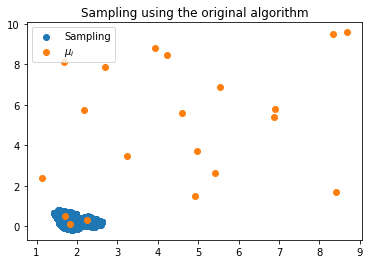

In [24]:
Nb_burn=5000
results_toy_original=MHwG_exo2(50000,init=None,progress=True,sigma_prop=[1e-2,1e-2],prob_k=0.5)
plt.figure()
plt.scatter(results_toy_original[Nb_burn:,0],results_toy_original[Nb_burn:,1],label='Sampling')
plt.scatter(mu[:,0],mu[:,1],label='$\mu_i$')
plt.legend(loc='upper left',fontsize=10)
plt.title('Sampling using the original algorithm')
plt.show()

In [25]:
results_toy=mh_srw(log_pi_gmm,50000,init=[8,2],sigma_prop=[1e-1,1e-1])

Acceptance rate: 0.55264


Acceptance rate: 0.58636
Acceptance rate: 0.55296
Acceptance rate: 0.57306
Acceptance rate: 0.55484
Acceptance rate: 0.5511


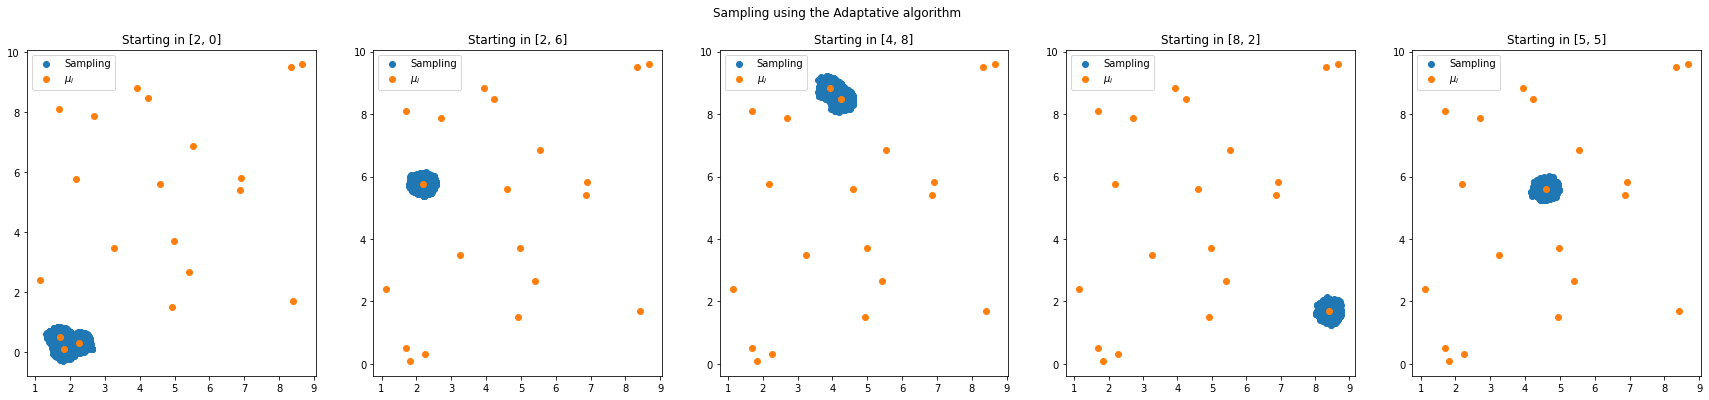

In [26]:
lista_init=[[2,0],[2,6],[4,8],[8,2],[5,5]]
n_init=5000
Nb_burn=int(n_init/10)

plt.figure(figsize=(30,6))
for init in range(len(lista_init)):
    results_toy=mh_srw(log_pi_gmm,50000,init=lista_init[init],sigma_prop=[1e-1,1e-1])
    plt.subplot(1,5,init+1)
    plt.scatter(results_toy[Nb_burn:,0],results_toy[Nb_burn:,1],label='Sampling')
    plt.scatter(mu[:,0],mu[:,1],label='$\mu_i$')
    plt.legend(loc='upper left',fontsize=10)
    plt.title('Starting in '+str(lista_init[init]))
plt.suptitle('Sampling using the Adaptative algorithm')
plt.show()

We can see that the algorithm fails to sample from $\pi$ as it is not able to generate samples for all the different Gaussians. Moreover, it only generates samples around the mode or modes that are the closest to the initial sample. Hence, it does not work properly to generate samples from the multimodal target distribution $\pi$.

### 2.B – Parallel Tempering

#### 1. Implement the Parallel Tempering algorithm.

We can explore the $K$ chains in parallel in order to explore all the space. In this case,  we switch the chains with a $\sigma_{\text{prop}}$ big and a big $T_i$ to be able to go further.


In [27]:
def pi_gmm(x,mu=mu,sigma=sigma,w=w,Nb_gauss=20):
    # likelihood of the GMM
    pi=0
    for i in range(Nb_gauss):
        pi+=w[i]/(2*np.pi*sigma[i]**2)*np.exp(-(x-mu[i,:]).T.dot(x-mu[i,:])/(2*sigma[i]**2))
    return pi
def PT(T,N,pi_gmm):
    # Parallel Tempering algorithm
    def next_x(x_old,y_old,pi_gmm,t,sigma):
        # generation of move in the x axis
        x_new=np.random.normal(loc=x_old,scale=sigma)
        # compute the acceptance
        alpha=min(0,np.log(pi_gmm(np.array([x_new,y_old])))*(1./(1.*t))-np.log(pi_gmm(np.array([x_old,y_old])))*(1./(1.*t)))
        if (np.log(np.random.rand())<alpha):
            return x_new
        return x_old

    def next_y(x_old,y_old,pi_gmm,t,sigma):
        # generation of move in the y axis
        y_new=np.random.normal(loc=y_old, scale=sigma)
        # compute the acceptance
        alpha=min(0,np.log(pi_gmm(np.array([x_old,y_new])))*(1./(1.*t))-np.log(pi_gmm(np.array([x_old,y_old])))*(1./(1.*t)))
        if (np.log(np.random.rand())<alpha):
            return y_new
        return y_old
    def swap_stage(val_0,val_1,idx_0,idx_1,T,pi_gmm):
        # considering to swap between two chains
        alpha=pi_gmm(val_0)**(1/T[idx_1])*pi_gmm(val_1)**(1./(1.*T[idx_0]))
        alpha=min(1,alpha/(pi_gmm(val_1)**(1./(1.*T[idx_1]))*pi_gmm(val_0)**(1./(1.*T[idx_0]))))
        aux_0_x=val_0[0]
        aux_0_y=val_0[1]
        aux_1_x=val_1[0]
        aux_1_y=val_1[1]
        if (np.random.rand()<alpha):
            return aux_1_x,aux_1_y,aux_0_x,aux_0_y
        return aux_0_x,aux_0_y,aux_1_x,aux_1_y
    K=len(T)
    samples=np.zeros((K,2,N+1))
    for i in range(N):
        # compute the samples for the i iteration
        for t in range(K):
            samples[t,0,i+1]=next_x(samples[t,0,i],samples[t,1,i],pi_gmm,T[t],sigma=0.25*np.sqrt(T[t]))
            samples[t,1,i+1]=next_y(samples[t,0,i+1],samples[t,1,i],pi_gmm,T[t],sigma=0.25*np.sqrt(T[t]))
            
        # considering the swapping between two chains
        sub=np.random.choice(np.arange(K),size=2,replace=False)
        val_0=samples[sub[0],:,i+1]
        val_1=samples[sub[1],:,i+1]
        idx_0=sub[0]
        idx_1=sub[1]
        aux_0_x,aux_0_y,aux_1_x,aux_1_y=swap_stage(val_0,val_1,idx_0,idx_1,T,pi_gmm)
        samples[sub[0],0,i+1]=aux_0_x
        samples[sub[0],1,i+1]=aux_0_y
        samples[sub[1],0,i+1]=aux_1_x
        samples[sub[1],1,i+1]=aux_1_y
    return samples

#### 2. In order to illustrate the performance of the algorithm, use your code to sample from the distribution $\pi$ of Part A.

In [28]:
T=np.array([60, 21.6, 7.7, 2.8, 1])
results_PT=PT(T,10000,pi_gmm)

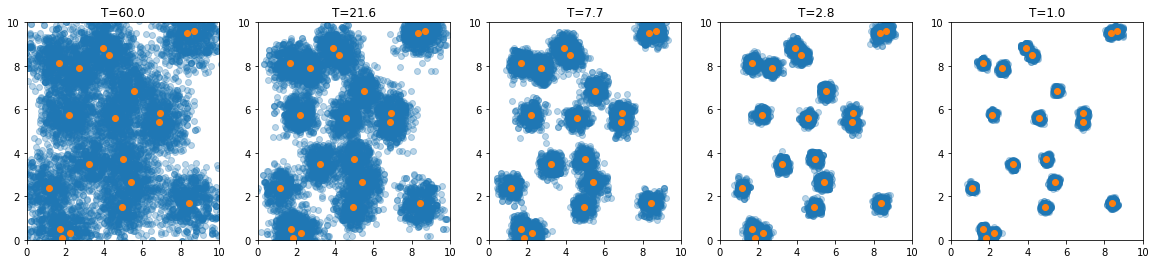

In [29]:
N_burn=int(n_iter/10)
plt.figure(figsize=(20,4))
K=len(T)
for i in range(K):
    plt.subplot(1,5,i+1)
    plt.xlim(0,10)
    plt.ylim(0,10)
    plt.title('T='+str(T[i]))
    plt.scatter(results_PT[i,0,N_burn:],results_PT[i,1,N_burn:],alpha=0.3)
    plt.scatter(mu[:,0],mu[:,1])
plt.show()

From the different figures we can see that having a high temperature allow the algorithm to easily swap between the modes. This fact allow the algorithm to explore all the modes in exchange of a high computational cost. We might remark that it seems to work well as it is able to capture all the different modes. However, we have to highlight that it might not work as good as in this case if we consider a different sequence of temperatures and covariances matrix than the ones given.

## Exercise 3: Bayesian analysis of a one-way random effects model

####  1. Write the density of the a posteriori distribution $(X,\mu,\sigma^2,\tau^2)$— it can be given up to a normalizing constant — i.e the density of the distribution $(Y,X,\mu,\sigma^2,\tau^2)$.

By Bayes' Theorem we have that

$$
P(X,\mu,\sigma^2,\tau^2|Y)\propto P(X,\mu,\sigma^2,\tau^2,Y)=\\
P(Y|X,\mu,\sigma^2,\tau^2) P(X|\mu,\sigma^2,\tau^2)
P(\mu,\sigma^2,\tau^2)
.$$

Moreover,

$$P(Y|X,\mu,\sigma^2,\tau^2)=\prod_{i=1}^{n} \prod_{j=1}^{k_i} \frac{1}{\tau \sqrt{2\pi}} \exp \left(-\frac{1}{2\tau^2}(y_{i,j} - x_i)^2\right)\\ 
P(X|\mu, \sigma^2,\tau^2 ) \propto  \frac{1}{\sigma^N} \exp \left(- \frac{\sum_{i=1}^{N} (x_i - \mu)^2}{2 \sigma^2}\right)\\
P(\mu, \sigma^2,\tau^2 )  \propto  \frac{1}{\sigma^{2(1+\alpha)}} \exp \left(- \frac{\beta}{\sigma^2}\right)  \frac{1}{\tau^{2(1+\gamma)}} \exp \left(- \frac{\beta}{\tau^2}\right) .$$


So 

$$
P(X,\mu,\sigma^2,\tau^2|Y)\propto 
\tau^{-2(\frac{n \cdot k}{2}+1+\gamma)} \sigma^{-2(\frac{n}{2}+1+\alpha)} \\ \exp\left(-\frac{1}{2\tau^2} \sum_{i=1}^{N} \sum_{j=1}^{k_i} (y_{ij}-x_{i})^2-\frac{1}{2\sigma^2}\sum_{i=1}^{N} (x_i - \mu)^2 - \beta (\sigma^{-2} + \tau^{-2})\right)
.$$

#### 2. Implement a Gibbs sampler which updates in turn $(\sigma^2,\tau^2,\mu,X)$ one at a time.

In [30]:
from scipy.stats import invgamma

In [31]:
def gibbs(Y,alpha,beta,gamma,n_iter=1000):
    # Gibbs sampler for the considered distribution
    # we use sigma and tau instead of sigma^2 and tau^2
    N,K=Y.shape
    mu=np.zeros(n_iter+1)
    sigma=np.ones(n_iter+1)
    tau=np.ones(n_iter+1)
    X=np.zeros((n_iter+1,N))
    Y_sum=Y.sum(axis=1)
    for i in range(1,n_iter+1):
        # sigma update
        a=alpha+N/2
        b=beta+((X[i-1]-mu[i-1])**2).sum()/2
        sigma[i]=np.sqrt(invgamma(a,scale=b).rvs())
        
        # tau update
        a=gamma+N*K/2
        b=beta+((Y-X[i-1][:,None])**2).sum()/2
        tau[i]=np.sqrt(invgamma(a,scale=b).rvs())
        
        
        # mu update
        mu[i]=X[i-1].mean()+np.random.randn()*sigma[i]/np.sqrt(N)
        
        # sample update
        for j in range(N):
            s=np.sqrt(((sigma[i]*tau[i])**2)/(K*sigma[i]**2+tau[i]**2))
            m=(Y_sum[j]*sigma[i]**2+mu[i]*tau[i]**2)/(K*sigma[i]**2+tau[i]**2)
            X[i,j]=m+np.random.randn()*s
            
    return sigma,tau,mu,X

#### 3. Implement a Block-Gibbs sampler which updates $\sigma^2$, then $\tau^2$ and then the block $(X,\mu)$.

In [32]:
def block_gibbs(Y,alpha,beta,gamma,n_iter=1000):
    # Block Gibbs sampler for the considered distribution
    # we use sigma and tau instead of sigma^2 and tau^2
    # Block groups:
    ## sigma
    ## tau
    ## mu and X
    N,K=Y.shape
    mu=np.zeros(n_iter+1)
    sigma=np.ones(n_iter+1)
    tau=np.ones(n_iter+1)
    X=np.zeros((n_iter+1,N))
    Y_sum=Y.sum(axis=1)
    for i in range(1,n_iter+1):
        # sigma update
        a=alpha+N/2
        b=beta+((X[i-1]-mu[i-1])**2).sum()/2
        sigma[i]=np.sqrt(invgamma(a,scale=b).rvs())
        
        # tau update
        a=gamma+N*K/2
        b=beta+((Y-X[i-1][:,None])**2).sum()/2
        tau[i]=np.sqrt(invgamma(a,scale=b).rvs())
        
        # mu and X updates
        mu[i]=X[i-1].mean()+np.random.randn()*sigma[i]/np.sqrt(N)
        for j in range(N):
            s=np.sqrt(((sigma[i])**2)/(K*sigma[i]**2+tau[i]**2))
            m=(Y_sum[j]*sigma[i]**2)/(K*sigma[i]**2+tau[i]**2)
            X[i,j]=m+np.random.randn()*s*tau[i]**2
            
    return sigma,tau,mu,X

#### 4. Discuss the theoretical performance of these two algorithms.

Block Gibbs upload the different variables in groups instead of doing one time each one. This way of uploading the variables makes this version faster and with a smaller computational cost than the Gibbs sampler. Specially, this is usefull when the computation of the likelihood or log-likelihood is very high or there are some variables that are highly correlated. Although, it might imply the use of complex conditional distributions.

#### 5.  Test your code on a synthetic dataset $Y=\{y_{i,j}, i \in \{1,\cdots, N\},j \in \{1,\cdots,k_i\}\}$ generated from the previous model.

In [33]:
N=1000
K=100
mu_init = 10
sigma_init = 1
tau_init = 0.5

alpha=0.1
beta=0.1
gamma=0.1
num_samples = 10000
Y = np.zeros((N,K))
for i in range(N):
    X_aux = np.random.normal(loc=mu_init,scale=sigma_init)
    eps_aux = np.random.normal(loc=0,scale=tau_init,size=K)
    Y[i,:] = X_aux + eps_aux

In [34]:
sigma,tau,mu,X=gibbs(Y,alpha,beta,gamma,n_iter=1000)

In [35]:
sigma_block,tau_block,mu_block,X_block=block_gibbs(Y,alpha,beta,gamma,n_iter=1000)

In [37]:
print('---Original parameters---')
print('mu: ', mu_init)
print('sigma: ',sigma_init)
print('tau: ',tau_init)
print('----------Gibbs----------')
print('mu: ', np.mean(mu))
print('sigma: ', np.mean(sigma))
print('tau: ',np.mean(tau))
print('-------Block Gibbs-------')
print('mu: ', np.mean(mu_block))
print('sigma: ', np.mean(sigma_block))
print('tau: ',np.mean(tau_block))

---Original parameters---
mu:  10
sigma:  1
tau:  0.5
----------Gibbs----------
mu:  9.879838068322734
sigma:  0.9737038738643018
tau:  0.6453983951716608
-------Block Gibbs-------
mu:  9.973643267957929
sigma:  1.0047006162703536
tau:  0.5533572649315138


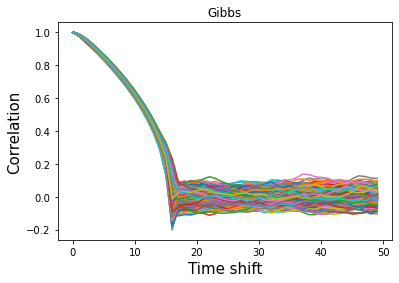

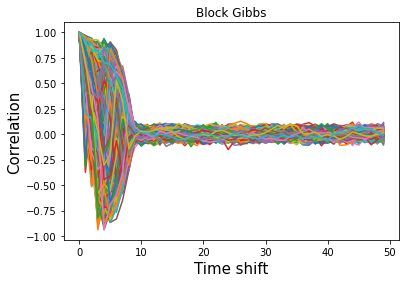

In [38]:
N,K=X.shape
plt.figure()
for i in range(K):
    plt.plot(crosscorr(X[:,i],X[:,i],max_lag=50))
plt.xlabel('Time shift',fontsize=15)
plt.ylabel('Correlation',fontsize=15)
plt.title('Gibbs')
plt.show()
N,K=X_block.shape
plt.figure()
for i in range(K):
    plt.plot(crosscorr(X_block[:,i],X_block[:,i],max_lag=50))
plt.xlabel('Time shift',fontsize=15)
plt.ylabel('Correlation',fontsize=15)
plt.title('Block Gibbs')
plt.show()

We can see that the Block Gibbs produce better results than the Gibbs algorithm as the values are closer to the original ones and the correlation decreases before.